<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_cat_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

100%|██████████| 787M/787M [00:08<00:00, 92.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [3]:
print(len(os.listdir(f'{path}/kagglecatsanddogs_3367a/PetImages/Cat/')))
print(len(os.listdir(f'{path}/kagglecatsanddogs_3367a/PetImages/Dog/')))

12491
12470


In [6]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

CAT_SOURCE_DIR = f'{path}/kagglecatsanddogs_3367a/PetImages/Cat/'
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = f'{path}/kagglecatsanddogs_3367a/PetImages/Dog/'
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 24689 images belonging to 2 classes.
Found 4723 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/247 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - acc: 0.5400 - loss: 0.9796

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


247/247 ━━━━━━━━━━━━━━━━━━━━ 70s 257ms/step - acc: 0.5721 - loss: 0.8304 - val_acc: 0.7436 - val_loss: 0.5234
Epoch 2/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 64s 202ms/step - acc: 0.7255 - loss: 0.5381 - val_acc: 0.7804 - val_loss: 0.4573
Epoch 3/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - acc: 0.7815 - loss: 0.4646 - val_acc: 0.8277 - val_loss: 0.4031
Epoch 4/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - acc: 0.8164 - loss: 0.4073 - val_acc: 0.8615 - val_loss: 0.3313
Epoch 5/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - acc: 0.8420 - loss: 0.3567 - val_acc: 0.8812 - val_loss: 0.2802
Epoch 6/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - acc: 0.8741 - loss: 0.2898 - val_acc: 0.9227 - val_loss: 0.2083
Epoch 7/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - acc: 0.9028 - loss: 0.2297 - val_acc: 0.9238 - val_loss: 0.1882
Epoch 8/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 50s 197ms/step - acc: 0.9356 - loss: 0.1629 - val_acc: 0.9579 - val_loss: 0.1111
Epoch 9/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 50s

<Figure size 640x480 with 0 Axes>

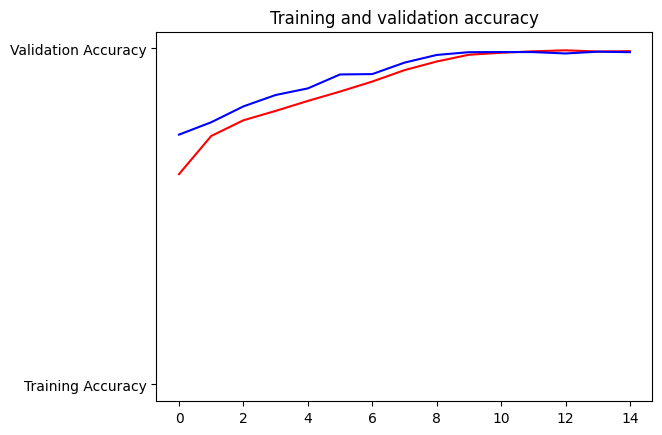

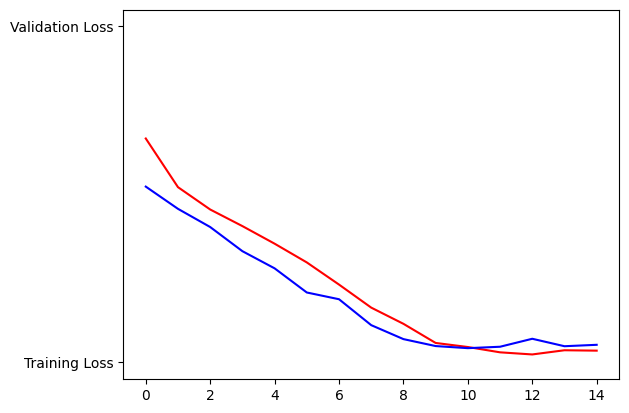

<Figure size 640x480 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()